# Relative Mutation Dosage - Notes and Simulated Limit of Detection Analysis

## Requirements

The family CSV file from the pipeline output. Please note that this CSV only contains SNPs and no multiallelic variants. 

## What is in this Notebook?

* Test code for Relative Mutation Dosage (RMD) analysis. We use the same SPRT algorithm as in the RHDO analysis but operate it on the data from a single SNP

* RMD Simulation - For each sequencing depth and fetal fraction combination - we run 1000 simulations and see how many of these fit into Affected, Unaffected and Unclassified categories

In [1211]:
import pandas as pd
from random import choices
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

In [1212]:
# Set some variables

family_csv = '../../181129_NB551415_0005_AHWW37BGX7/family_csvs/181129_NB551415_0005_AHWW37BGX7_all_chr_qfiltered_anno_selected_FAM008.csv'

maternal_sample = '14M01888'
proband_sample = '14M02709'
plasma_sample = 'F5-2-DIL'

gene = 'EDA'

fetal_fraction = 0.18


# Which variant are we looking for?
variant_chrom = 'X'
variant_pos = 69253265
variant_ref = 'C'
variant_alt = 'T'

print ('Performing RMD X-Linked Analysis')
print (f'The plasma sample is:\t{plasma_sample}')
print (f'Selected gene for analysis is:\t{gene}')
print (f'Minimum SNP genotype depth is set to:\t{min_genotype_depth}')

Performing RMD X-Linked Analysis
The plasma sample is:	F5-2-DIL
Selected gene for analysis is:	EDA
Minimum SNP genotype depth is set to:	30


In [1213]:
df = pd.read_csv(family_csv, sep='\t')

In [1214]:
df.head()

,CHROM,POS,REF,ALT,ID,GENE,14M01888.GT,14M01888.AD,14M01888.DP,14M02709.GT,14M02709.AD,14M02709.DP,F5-2-DIL.GT,F5-2-DIL.AD,F5-2-DIL.DP
0,7,114498885,T,C,.,CFTR,T/T,"130,0",130,T/T,"120,0",120,T/T,"96,0",96
1,7,114499932,T,C,.,CFTR,C/C,"1,331",332,C/C,"0,419",419,C/C,"0,205",205
2,7,114537363,T,A,.,CFTR,A/A,"2,400",402,A/A,"0,477",477,A/A,"0,249",249
3,7,114539933,A,C,.,CFTR,C/C,"1,195",196,C/C,"0,155",159,C/C,"0,155",160
4,7,114559777,G,A,.,CFTR,G/G,"146,0",146,G/G,"152,0",152,G/G,"88,0",88


In [1215]:
def order_columns(df):
    """
    Ensure that the columns are ordered as:
    
    CHROM, POS, REF, ALT, ID, GENE, maternal, proband, plasma

    """
    
    df = df[['CHROM',
             'POS',
             'REF',
             'ALT',
             'ID',
             'GENE',
             maternal_sample +'.GT',
             maternal_sample +'.AD',
             maternal_sample +'.DP',
             proband_sample +'.GT',
             proband_sample +'.AD',
             proband_sample +'.DP',            
             plasma_sample +'.GT',
             plasma_sample +'.AD',
             plasma_sample +'.DP',
            ]]
    
    return df

In [1216]:
# Make sure columns are in the right order

df = order_columns(df)

In [1217]:
def fix_column_names(columns):
    """
    Change column names to valid python variable names by replacing '.' with '_'
    
    """
    
    fixed_columns = []
    
    for column_name in columns:
        
        fixed_column_name = column_name.replace('.', '_').replace('-', '_')
        
        if fixed_column_name not in ['CHROM', 'POS', 'REF', 'ALT','ID','GENE']:
            
            fixed_column_name = 'sample_' + fixed_column_name
        
        fixed_columns.append(fixed_column_name)
    
    return fixed_columns

In [1218]:
# Our sample names may not be valid python variable names so take out - and add sample_ string to start

df.columns = fix_column_names(df.columns)
maternal_sample = maternal_sample.replace('-', '_')
proband_sample = proband_sample.replace('-', '_')
plasma_sample = plasma_sample.replace('-', '_')

maternal_sample = 'sample_' + maternal_sample
proband_sample = 'sample_' + proband_sample
plasma_sample = 'sample_' + plasma_sample

In [1219]:
df.head()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,sample_14M02709_AD,sample_14M02709_DP,sample_F5_2_DIL_GT,sample_F5_2_DIL_AD,sample_F5_2_DIL_DP
0,7,114498885,T,C,.,CFTR,T/T,"130,0",130,T/T,"120,0",120,T/T,"96,0",96
1,7,114499932,T,C,.,CFTR,C/C,"1,331",332,C/C,"0,419",419,C/C,"0,205",205
2,7,114537363,T,A,.,CFTR,A/A,"2,400",402,A/A,"0,477",477,A/A,"0,249",249
3,7,114539933,A,C,.,CFTR,C/C,"1,195",196,C/C,"0,155",159,C/C,"0,155",160
4,7,114559777,G,A,.,CFTR,G/G,"146,0",146,G/G,"152,0",152,G/G,"88,0",88


In [1220]:
def genotype_sample(df, sample_name):
    """
    Return whether a sample is HOM or HET
    
    Add a NA if sample is ./. or 1/. or something else wierd
    """
    
    gt = df[sample_name+'_GT']
    
    if '/' in gt:
        
        gt = gt.split('/')
    
    elif '|' in gt:
        
        gt = gt.split('|')
        
    else:
        
        raise ValueError(f"Found a wierd genotype in variant {df['CHROM']} {df['POS']}")
        
    if (gt[0] not in 'ATGC') or (gt[1] not in 'ATGC'):
        
        return 'NA'
        
    if gt[0] == gt[1]:
        
        return 'HOM'
    else:
        return 'HET'
    
    
def get_allele_depth_ref(df, sample_name):
    """
    For a given sample split the AD column into AD for ref and alts
    
    """
    
    ad = df[sample_name+'_AD']
    
    ad = ad.split(',')
    
    return ad[0]
    
def get_allele_depth_alt(df, sample_name):
    """
    For a given sample split the AD column into AD for ref and alts
    
    """
    
    ad = df[sample_name+'_AD']
    
    ad = ad.split(',')
    
    return ad[1]


In [1221]:

# Apply genotype ref depth function

df[maternal_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = maternal_sample )
df[proband_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = proband_sample )
df[plasma_sample + '_AD_ref'] = df.apply(get_allele_depth_ref, axis=1, sample_name = plasma_sample )

# Apply genotype alt depth function

df[maternal_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = maternal_sample )
df[proband_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = proband_sample )
df[plasma_sample + '_AD_alt'] = df.apply(get_allele_depth_alt, axis=1, sample_name = plasma_sample )

In [1222]:
def sprt_calculate_d(fetal_fraction):
    """
    Calculate the d value needed for SPRT analysis:
    
    See the following papers for more information:
    
    1) https://www.ncbi.nlm.nih.gov/pubmed/21148127
    
    2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1934923/bin/pnas_0705765104_index.html
    
    The d value is used by the function sprt_perform_test()
    
    """
    
    # q0 is the allele imbalance if the null hypothesis is correct i.e. the fetus has the normal allele.
    # the 0.5 value is because we would expect to see this much deviation from the 0.5 allele balance seen \
    # in HET SNPs and then some more deviancy depending on the fetal fraction.
    
    
    q0 = 0.5 - (fetal_fraction / 2)
    
    # q1 is the allele imbalance if the null hypothesis is incorrect i.e. the fetus has the mutant allele.

    q1 = 0.5 + (fetal_fraction / 2)
    
    
    d_value = (1 - q1) / (1 - q0)
    
    return d_value

def sprt_calculate_g(fetal_fraction):
    """
    Calculate the g value needed for SPRT analysis:
    
    See the following papers for more information:
    
    1) https://www.ncbi.nlm.nih.gov/pubmed/21148127
    
    2) https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1934923/bin/pnas_0705765104_index.html
    
    The g value is used by the function sprt_perform_test()
    
    """
    
    # q0 is the allele imbalance if the null hypothesis is correct i.e. the fetus has the normal allele.
    # the 0.5 value is because we would expect to see this much deviation from the 0.5 allele balance seen \
    # in HET SNPs and then some more deviancy depending on the fetal fraction.
    
    q0 = 0.5 - (fetal_fraction/2)

    # q1 is the allele imbalance if the null hypothesis is incorrect i.e. the fetus has the mutant allele.

    q1 = 0.5 + (fetal_fraction/2)

    g_value = ( q1*(1 - q0) ) / ( q0*(1 - q1) )
    
    return g_value

In [1223]:
def sprt_calculate_upper_boundry(total_read_count, d_value, g_value):
    """
    Calculate the upper value for the SPRT classification.
    
    """
    
    return (( np.log(1200) / total_read_count ) - np.log(d_value)) / np.log(g_value)

In [1224]:
def sprt_calculate_lower_boundry(total_read_count, d_value, g_value):
    """
    Calculate the lower value for the SPRT classification.
    
    """
    
    return (( np.log(float(1) / float(1200) )/ total_read_count ) - np.log(d_value)) / np.log(g_value)

In [1225]:
def sprt_perform_test(df, d_value, g_value):
    """
    Function to call the status of each snp as hapA, hapB or Unclassified.
    
    Input:
    
    df = The processed dataframe containing the X-linked SNP data.
    d_value = The value calculated by sprt_calculate_d()
    g_value = The value calculated by sprt_calculate_g()
    
    Output:
    
    df = A new dataframe containing seven additional rows:
    
    cumulative_sum_hapa
    cumulative_sum_hapb
    cumulative_ratio
    cumulative_total
    upper_boundry
    lower_boundry
    status
    
    
    """
    
    # Loop through each snp
    for snp in df.itertuples():
        
        # Calculate the cumlative sum
        cumulative_sum_hapa = cumulative_sum_hapa + snp.hapA_count
        cumulative_sum_hapb = cumulative_sum_hapb + snp.hapB_count
        
        # Calculate the cumlative allele balance between hapA and hapB
        cumulative_ratio = cumulative_sum_hapa / (cumulative_sum_hapa + cumulative_sum_hapb)
        
        cumulative_total = cumulative_sum_hapa + cumulative_sum_hapb
        
        # Calculate upper and lower SPRT boundaries
        upper_boundry = sprt_calculate_upper_boundry(cumulative_total, d_value, g_value )
        
        lower_boundry = sprt_calculate_lower_boundry(cumulative_total, d_value, g_value)
        
        # call blocks either hapA, hapB or Unclassified
        
        if (cumulative_ratio > upper_boundry) and snp_count >= min_snps_per_block:
            
            status = 'hapA'
            cumulative_sum_hapa = 0
            cumulative_sum_hapb = 0
            snp_count = 0
            
            
        elif cumulative_ratio < lower_boundry and snp_count >= min_snps_per_block:
            
            status = 'hapB'
            cumulative_sum_hapa = 0
            cumulative_sum_hapb = 0
            snp_count = 0
            
        else:
            
            status = 'Unclassified'
            
        snp_count = snp_count + 1
        
        #update dataframe with calculated values
        df.at[snp.Index, 'cumulative_sum_hapa'] = cumulative_sum_hapa
        df.at[snp.Index, 'cumulative_sum_hapb'] = cumulative_sum_hapb
        df.at[snp.Index, 'cumulative_ratio'] = cumulative_ratio
        df.at[snp.Index, 'cumulative_total'] = cumulative_total
        df.at[snp.Index, 'upper_boundry'] = upper_boundry
        df.at[snp.Index, 'lower_boundry'] = lower_boundry
        df.at[snp.Index, 'status'] = status
        
    return df

In [1226]:
def perform_sprt_rmd(df, d_value, g_value, plasma_sample):
    
    ref_count = df[plasma_sample + '_AD_ref']
    alt_count = df[plasma_sample + '_AD_alt']
    depth = int(ref_count) + int(alt_count)
    
    cumulative_ratio = int(alt_count) / (int(alt_count) + int(ref_count))
    upper_boundry = sprt_calculate_upper_boundry(depth, d_value, g_value )
    lower_boundry = sprt_calculate_lower_boundry(depth, d_value, g_value)
    
    
    if (cumulative_ratio > upper_boundry):
            
        status = 'Affected'        
            
    elif cumulative_ratio < lower_boundry:
            
        status = 'Unaffected'

            
    else:
            
        status = 'Unclassified'
            
    return status

In [1227]:
# Get variant
df = df[(df['CHROM'] == variant_chrom) & (df['POS'] == variant_pos) & (df['REF'] == variant_ref) & (df['ALT'] == variant_alt)]

# Run SPRT on the variant
d_value = sprt_calculate_d(fetal_fraction)
g_value = sprt_calculate_g(fetal_fraction)

df['sprt_class'] = df.apply(perform_sprt_rmd, axis=1, args =(d_value, g_value, plasma_sample))

In [1228]:
# See results
df.head()

,CHROM,POS,REF,ALT,ID,GENE,sample_14M01888_GT,sample_14M01888_AD,sample_14M01888_DP,sample_14M02709_GT,...,sample_F5_2_DIL_GT,sample_F5_2_DIL_AD,sample_F5_2_DIL_DP,sample_14M01888_AD_ref,sample_14M02709_AD_ref,sample_F5_2_DIL_AD_ref,sample_14M01888_AD_alt,sample_14M02709_AD_alt,sample_F5_2_DIL_AD_alt,sprt_class
9944,X,69253265,C,T,.,EDA,C/T,"274,270",544,T/T,...,C/T,"146,144",290,274,1,146,270,261,144,Unclassified


## Simulated Limit of Detection Analysis

In [1229]:
def get_fetal_fraction_x_linked(cHapA, cHapB):
    """
    Use the formula from the Birmingham paper to calculate the fetal \
    fraction for X-linked data.
    
    https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4864947/
    
    cffDNA % = [(|cHapA – cHapB| * 2) / (cHapA + cHapB + |cHapA – cHapB|)] * 100
    
    """
    
    fetal_fraction = (abs(cHapA-cHapB)*2) / (cHapA + cHapB + abs(cHapA-cHapB)) *100
    
    return fetal_fraction

In [1297]:
# Note that the ffs list is a list of dilutions e.g 10% of the bases are from the fetus
# This will result in a calculated ff above the ff in the loop
# For example:
# If the mum is het GGGGG/TTTTT
# and we have a 10% dlution e.g. GGGGG/TTTTT +  fetus G
# then the calculated ff is: ((6-5)*2) / (6+5 + 1) *100 = 16.6%
# If we use this data to calculate lod later on then keep this in mind! As we will calculate the ff using the above \
# equation!


lod_list = []

depths = [50,100,200,300, 400, 500, 600, 700, 800, 900, 1000, 1500, 5000, 15000]
ffs = [2,5,8,10,15,20]
n_samples = 1000

for depth in depths:
    
    for ff in ffs:
        
        for n in range(n_samples):
            
            # sample with a specific weight 
            bias = (0.5 + ff/100) / (1+(ff/100))
            
            cnt = Counter(choices(['C', 'T'], k=depth, weights=[1-bias, bias]))
            affected = cnt['T']
            unaffected = cnt['C']
            calc_ff = get_fetal_fraction_x_linked(affected, unaffected)/100
            
            my_list = ['X', '69253265', 'C', 'T', depth, ff, unaffected, affected, n, calc_ff ]
            lod_list.append(my_list)

In [1298]:
lod_df = pd.DataFrame(lod_list, columns= ['CHROM', 'POS', 'REF', 'ALT', 'DEPTH', 'FF', 'sample_ref', 'sample_alt', 'sample_n', 'calculated_ff' ])

In [1299]:
def perform_sprt_rmd_lod(df):
    
    d_value = sprt_calculate_d(int(df['FF'])/100)
    g_value = sprt_calculate_g(int(df['FF'])/100)
    
    ref_count = df['sample_ref']
    alt_count = df['sample_alt']
    depth = int(ref_count) + int(alt_count)
    
    cumulative_ratio = int(alt_count) / (int(alt_count) + int(ref_count))
    upper_boundry = sprt_calculate_upper_boundry(depth, d_value, g_value )
    lower_boundry = sprt_calculate_lower_boundry(depth, d_value, g_value)
    
    
    if (cumulative_ratio > upper_boundry):
            
        status = 'Affected'        
            
    elif cumulative_ratio < lower_boundry:
            
        status = 'Unaffected'

            
    else:
            
        status = 'Unclassified'
            
    return status
    

In [1300]:
lod_df['sprt'] = lod_df.apply(perform_sprt_rmd_lod, axis=1)

In [1301]:
lod_df.head()

,CHROM,POS,REF,ALT,DEPTH,FF,sample_ref,sample_alt,sample_n,calculated_ff,sprt
0,X,69253265,C,T,50,2,24,26,0,0.076923,Unclassified
1,X,69253265,C,T,50,2,20,30,1,0.333333,Unclassified
2,X,69253265,C,T,50,2,21,29,2,0.275862,Unclassified
3,X,69253265,C,T,50,2,26,24,3,0.076923,Unclassified
4,X,69253265,C,T,50,2,21,29,4,0.275862,Unclassified


In [1302]:
pivot_lod = lod_df.pivot_table(values='ALT',index=['DEPTH', 'FF'], columns = ['sprt'], aggfunc='count')

In [1303]:
pivot_lod =(pivot_lod/1000) * 100


In [1304]:
pivot_lod = pivot_lod.fillna(0)

In [1305]:
#pivot_lod.to_csv('190114_c.811C-T_limit_of_detection_analysis_RMD_fixed.csv')

In [1306]:
pivot_lod = pivot_lod.reset_index()

In [1307]:
bias = (0.5 + (20/100)) / (1 + (20/100))
print(bias)
cnt = Counter(choices(['C', 'T'], k=100000, weights=[1-bias, bias]))
print (cnt)
print (cnt['T']/ cnt['C'])

0.5833333333333334
Counter({'T': 58253, 'C': 41747})
1.3953817040745442


In [1308]:
cnt = Counter(choices(['C', 'T'], k=1000, weights=[1-bias, bias]))

In [1309]:
lod_df.groupby(['DEPTH', 'FF']).mean()

sample_ref  sample_alt  sample_n  calculated_ff
DEPTH FF                                                 
50    2       24.353      25.647     499.5       0.190466
      5       23.811      26.189     499.5       0.199326
      8       23.273      26.727     499.5       0.205294
      10      22.681      27.319     499.5       0.229515
      15      21.780      28.220     499.5       0.250380
      20      20.952      29.048     499.5       0.287388
100   2       49.062      50.938     499.5       0.149473
      5       47.703      52.297     499.5       0.155528
      8       46.346      53.654     499.5       0.171859
      10      45.466      54.534     499.5       0.186442
      15      43.477      56.523     499.5       0.235341
      20      41.608      58.392     499.5       0.282179
200   2       98.148     101.852     499.5       0.107319
      5       94.857     105.143     499.5       0.128901
      8       92.242     107.758     499.5       0.156499
      10      90.836     109.164     499.5       0.173350
      15      87.056     112.944     499.5       0.225260
      20      83.571     116.429     499.5       0.276327
300   2      146.627     153.373     499.5       0.090171
      5      142.773     157.227     499.5       0.112329
      8      139.156     160.844     499.5       0.141033
      10     136.302     163.698     499.5       0.167512
      15     129.989     170.011     499.5       0.231814
      20     125.205     174.795     499.5       0.279659
400   2      196.123     203.877     499.5       0.082164
      5      190.489     209.511     499.5       0.104738
      8      185.325     214.675     499.5       0.139156
      10     182.348     217.652     499.5       0.161186
      15     173.912     226.088     499.5       0.227816
      20     166.861     233.139     499.5       0.281153
...              ...         ...       ...            ...
900   2      441.676     458.324     499.5       0.057982
      5      428.915     471.085     499.5       0.092515
      8      417.546     482.454     499.5       0.133391
      10     409.072     490.928     499.5       0.165108
      15     391.171     508.829     499.5       0.229679
      20     375.658     524.342     499.5       0.282253
1000  2      490.402     509.598     499.5       0.055249
      5      475.807     524.193     499.5       0.094145
      8      462.670     537.330     499.5       0.137562
      10     454.366     545.634     499.5       0.165975
      15     434.439     565.561     499.5       0.230386
      20     416.920     583.080     499.5       0.283868
1500  2      736.800     763.200     499.5       0.049473
      5      712.667     787.333     499.5       0.094751
      8      693.801     806.199     499.5       0.138383
      10     681.499     818.501     499.5       0.166410
      15     651.714     848.286     499.5       0.230852
      20     624.184     875.816     499.5       0.286497
5000  2     2453.574    2546.426     499.5       0.038606
      5     2382.560    2617.440     499.5       0.089376
      8     2313.698    2686.302     499.5       0.138374
      10    2273.655    2726.345     499.5       0.165714
      15    2171.402    2828.598     499.5       0.232078
      20    2084.475    2915.525     499.5       0.284809
15000 2     7351.952    7648.048     499.5       0.038628
      5     7140.305    7859.695     499.5       0.091414
      8     6943.743    8056.257     499.5       0.137981
      10    6815.937    8184.063     499.5       0.167071
      15    6522.680    8477.320     499.5       0.230483
      20    6251.545    8748.455     499.5       0.285326

[84 rows x 4 columns]

In [1310]:
pivot_lod.head()

sprt,DEPTH,FF,Affected,Unaffected,Unclassified
0,50,2,0.0,0.0,100.0
1,50,5,0.0,0.0,100.0
2,50,8,0.0,0.0,100.0
3,50,10,0.0,0.0,100.0
4,50,15,1.0,0.0,99.0


In [1311]:
melt_pivot = pivot_lod.melt(['DEPTH', 'FF'], ['Affected', 'Unaffected', 'Unclassified'])
melt_pivot = melt_pivot[melt_pivot['sprt'] =='Affected']

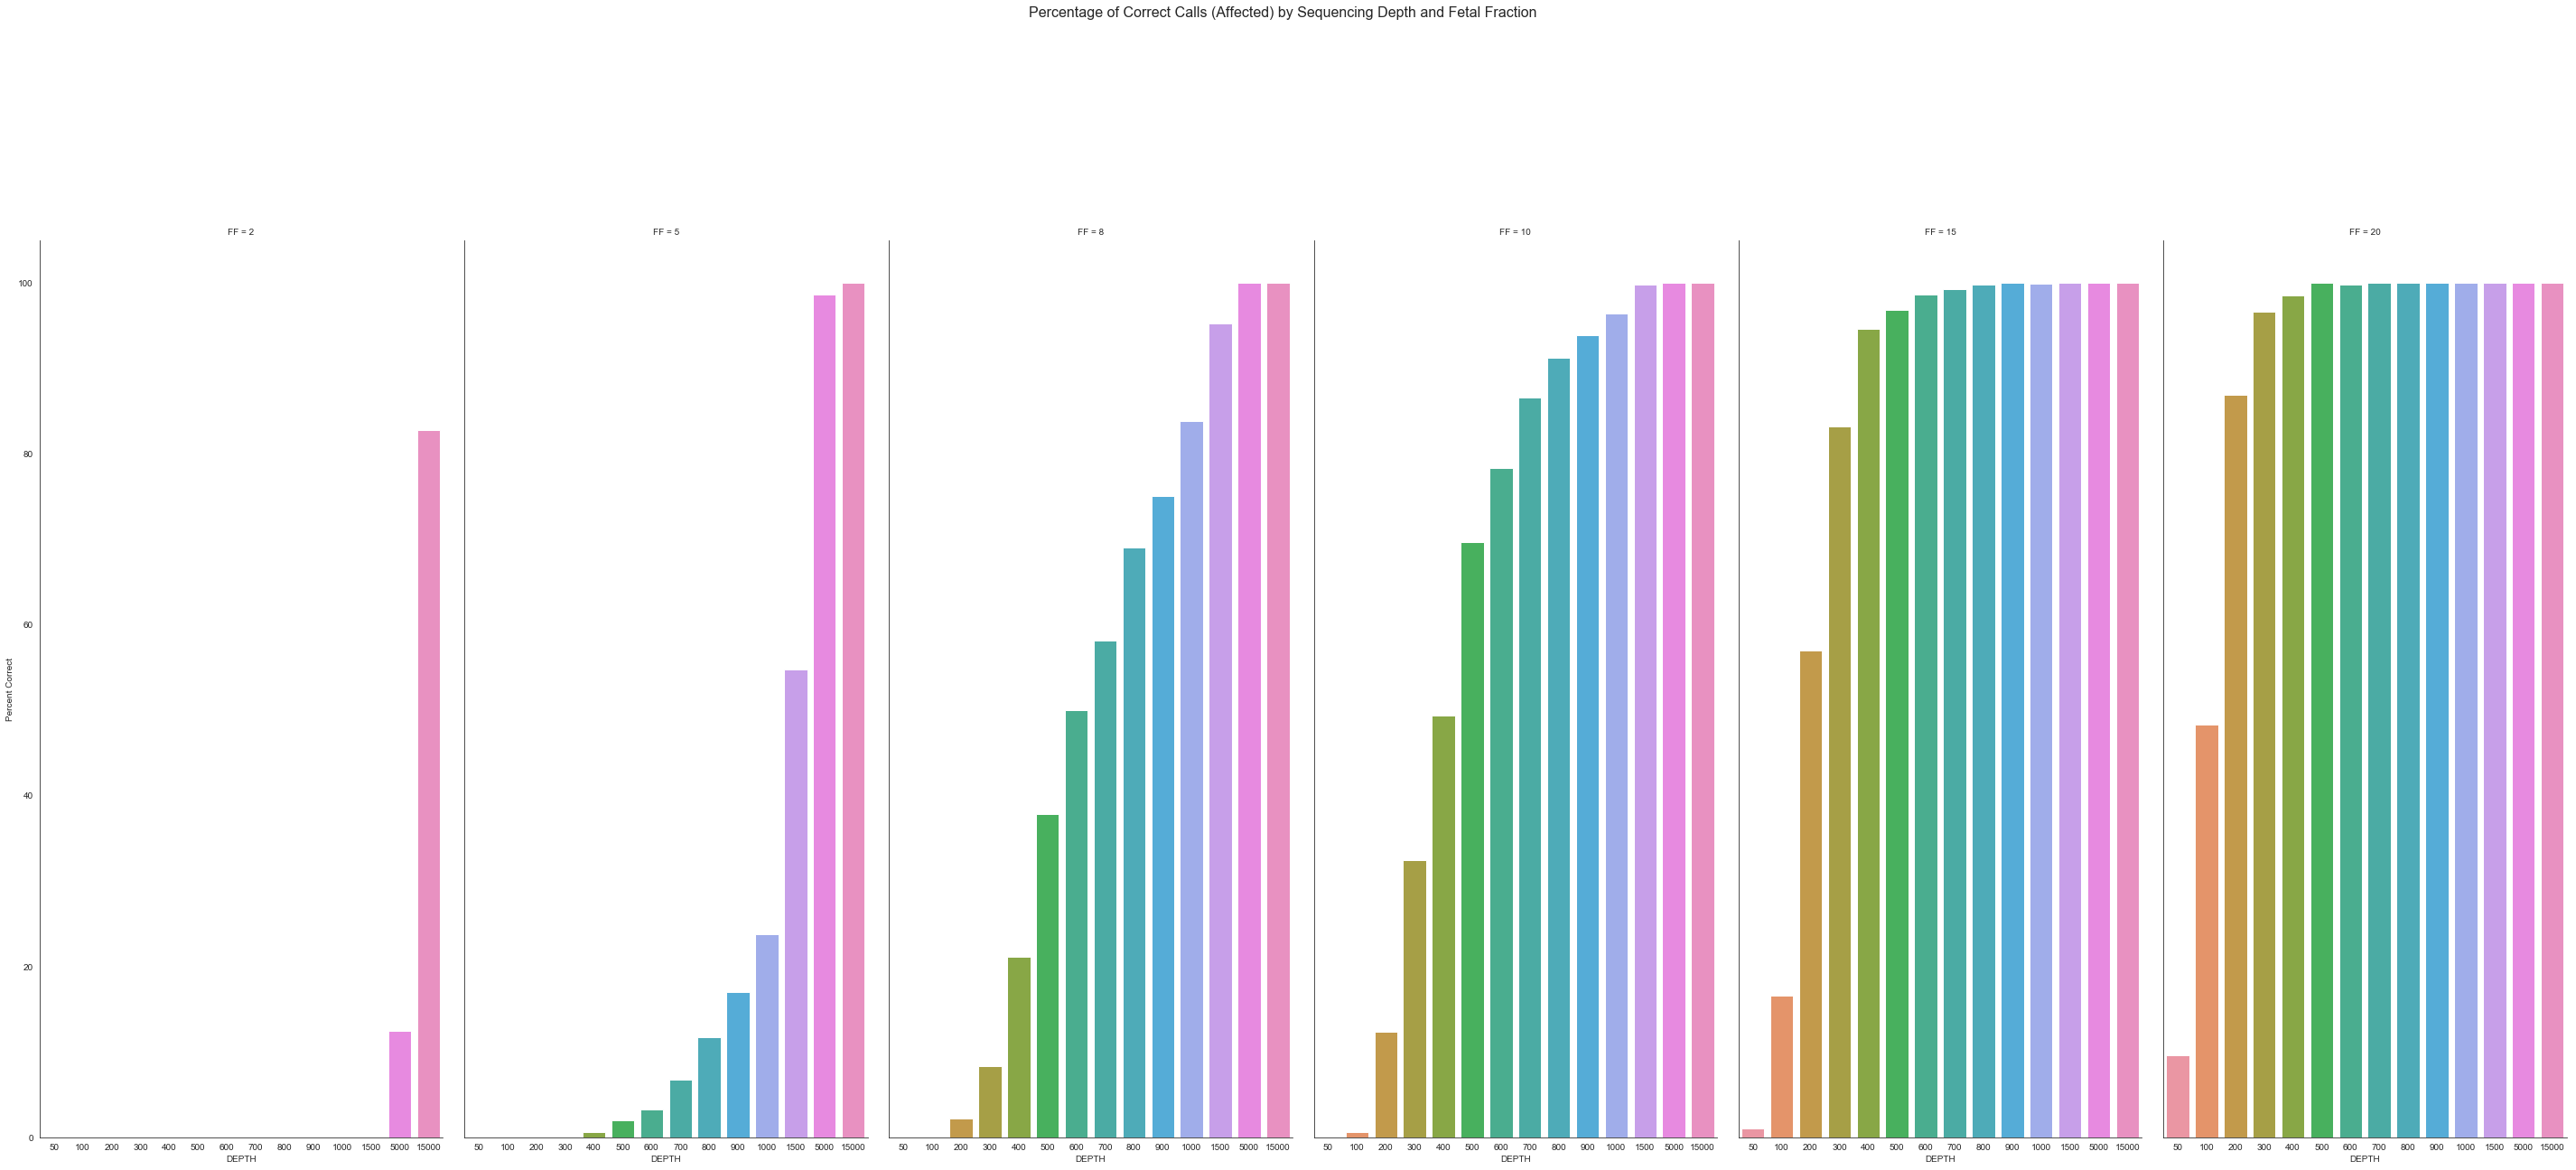

In [1312]:
g = sns.catplot(x='DEPTH', y='value', col='FF', data=melt_pivot, kind='bar')
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Percentage of Correct Calls (Affected) by Sequencing Depth and Fetal Fraction',fontsize=16)
g.axes[0,0].set_ylabel('Percent Correct')
g.fig.set_size_inches(40, 20)